In [2]:
##  BIOINFORMATICS ANALYSIS OF HIGH-CONFIDENCE GENE SEQUENCES

#This project is completed by: Eligijus Dagelis
#Code is available: https://github.com/eligidag/Bioinformatics-Analysis-of-High-Confidence-Gene-Sequences/blob/main/Bioinformatics%20Analysis%20of%20High-Confidence%20Gene%20Sequences.ipynb

##Introduction##

##This project aims to analyze high-confidence gene sequences from a given genome using various bioinformatics tools and techniques.       ##
##The workflow involves downloading the genome sequence, predicting genes, performing BLAST analysis, filtering high-confidence sequences, ##
##and analyzing the sequences for GC content, codon usage, and amino acid composition.                                                     ##

In [3]:
#Tools and Libraries Used

#Biopython: For sequence handling and manipulation.
#pandas: For data handling and analysis.
#matplotlib & seaborn: For data visualization.
#gffutils: For handling GFF files.
#AUGUSTUS: For gene prediction.
#BLAST: For sequence alignment.

In [4]:
## STEP 1: Acquiring the genome sequence
## Code downloads the genome sequence from NCBI using the provided accession ID and saves it in a FASTA file.

#imports necessary libraries
import os
from Bio import SeqIO, Entrez, SeqRecord
import pandas as pd
import matplotlib.pyplot as plt
import gffutils
import seaborn as sns

#email for NCBI
Entrez.email = "eligidag@gmail.com"

#NCBI accession ID
accession_id = "NC_060945.1"
filename = f"{accession_id}.fasta"

#checks if the file already exists and downloads it if not
if not os.path.isfile(filename):
    print(f"Downloading {accession_id} from NCBI...")
    net_handle = Entrez.efetch(
        db="nucleotide", id=accession_id, rettype="fasta", retmode="text"
    )
    with open(filename, "w") as out_handle:
        out_handle.write(net_handle.read())
    net_handle.close()
    print(f"Saved {filename}")

print("Parsing the FASTA file...")
record = SeqIO.read(filename, "fasta")
print(f"ID: {record.id}")
print(f"Sequence Length: {len(record.seq)}")
print(f"Description: {record.description}")

#saves the sequence in a cleaned format
cleaned_filename = f"cleaned_{accession_id}.fasta"
SeqIO.write(record, cleaned_filename, "fasta")
print(f"Saved cleaned sequence to {cleaned_filename}")

Parsing the FASTA file...
ID: NC_060945.1
Sequence Length: 45090682
Description: NC_060945.1 Homo sapiens isolate CHM13 chromosome 21, alternate assembly T2T-CHM13v2.0
Saved cleaned sequence to cleaned_NC_060945.1.fasta


In [5]:
## STEP 2: Gene Prediction Using AUGUSTUS
#Gene prediction was performed using AUGUSTUS outside of the VCS environment. The command used was:
### augustus --species=human cleaned_NC_060945.1.fasta > augustus_output.gff ###
#This command predicts the genes in the given genome and saves the output in GFF format.
#AUGUSTUS was installed locally, following tutorial available online: https://github.com/Gaius-Augustus/Augustus

In [6]:
## STEP 3:  Parsing the GFF File and Extracting Gene Sequences
## Code parses the GFF file using gffutils, extracts the gene sequences, and saves them in a new FASTA file.

#creates a database from the GFF file
db = gffutils.create_db(
    "augustus_output.gff",
    dbfn="augustus_output.db",
    force=True,
    keep_order=True,
    merge_strategy="merge",
    sort_attribute_values=True,
    disable_infer_genes=True,
    disable_infer_transcripts=True
)

#connects to the database
db = gffutils.FeatureDB("augustus_output.db")

#extracts the predicted gene sequences
predicted_genes = []
for gene in db.features_of_type("gene"):
    seq = record.seq[gene.start-1:gene.end]
    predicted_genes.append(SeqRecord.SeqRecord(seq, id=gene.id, description=""))

#writes the predicted gene to a new fasta file
predicted_genes_filename = "predicted_genes.fasta"
SeqIO.write(predicted_genes, predicted_genes_filename, "fasta")
print(f"Saved predicted genes to {predicted_genes_filename}")

Saved predicted genes to predicted_genes.fasta


In [7]:
## Step 4: BLAST Analysis and Filtering High-Confidence Hits
## Code loads the BLAST results, filters for high-confidence hits, and extracts the corresponding sequences.
#loads BLAST results into pandas DataFrame

# BLAST results to df 
blast_results_file = "blast_results.txt"
columns = [
    "query_id", "subject_id", "percent_identity", "alignment_length",
    "mismatches", "gap_opens", "query_start", "query_end",
    "subject_start", "subject_end", "e_value", "bit_score"
]

blast_df = pd.read_csv(blast_results_file, sep="\t", names=columns)

#first rows of DataFrame
print(blast_df.head())

#summary statistics
print(blast_df.describe())

#filters results for high confidence hits
high_confidence_hits = blast_df[blast_df["percent_identity"] >90]

#sort by bit score and select the top 100 hits (my current setup does not posses enough computing power to reasonably analyse more hits)
top_hits = high_confidence_hits.nlargest(100, "bit_score")
print(top_hits.head())


  query_id subject_id  percent_identity  alignment_length  mismatches  \
0   gene_2     gene_2           100.000             30503           0   
1   gene_2     gene_2            79.107               627         105   
2   gene_2     gene_2            79.107               627         105   
3   gene_2     gene_2            91.544               272          22   
4   gene_2     gene_2            91.544               272          22   

   gap_opens  query_start  query_end  subject_start  subject_end  \
0          0            1      30503              1        30503   
1         14        23701      24308           2460         1841   
2         14         1841       2460          24308        23701   
3          1        24304      24574          23084        23355   
4          1        23084      23355          24304        24574   

         e_value  bit_score  
0   0.000000e+00    56329.0  
1  4.700000e-112      409.0  
2  4.700000e-112      409.0  
3  1.710000e-101      374.0  
4 

In [8]:
#loads predicted genes fasta file
predicted_genes = list(SeqIO.parse(predicted_genes_filename, "fasta"))

#extracts sequences of high confidence hits
high_confidence_sequences = []
for index, row in top_hits.iterrows():
    for gene in predicted_genes:
        if gene.id == row["query_id"]:
            high_confidence_sequences.append(gene)
            break

#saves high confidence sequences to a new fasta file
high_confidence_file = "high_confidence_genes.fasta"
SeqIO.write(high_confidence_sequences, high_confidence_file,"fasta")
print(f"Saved high-confidence sequences to {high_confidence_file}")

Saved high-confidence sequences to high_confidence_genes.fasta


       gc_content
count  100.000000
mean    40.910791
std      4.862626
min     33.356428
25%     36.943728
50%     39.476145
75%     43.809186
max     53.996189


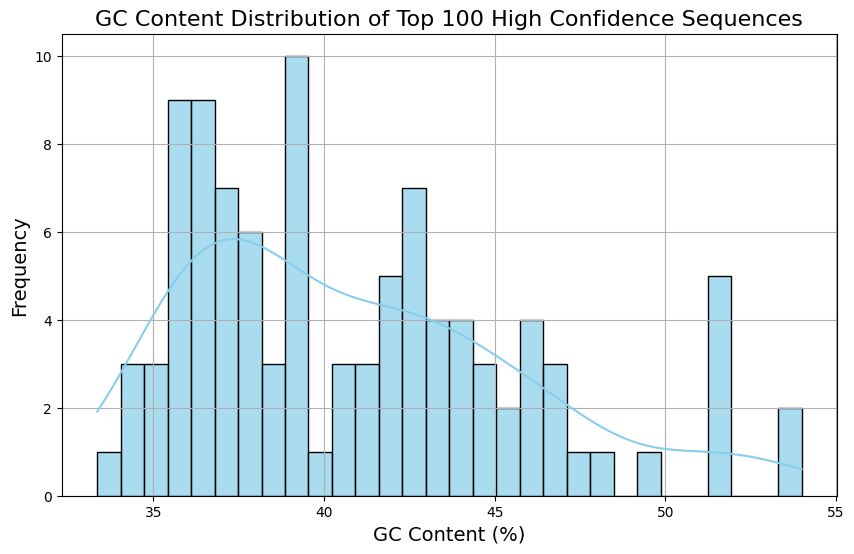

GC content results saved to gc_content_results.csv


In [9]:
##Step 5: GC Content Analysis
## code calculates the GC content for each high-confidence sequence and visualizes the distribution.

#function to calculate GC content
def gc_content(seq):
    return float(seq.count("G") + seq.count("C")) / len(seq) * 100

#calculates GC content for each sequence
gc_contents = []
for gene in high_confidence_sequences:
    gc = gc_content(str(gene.seq))
    gc_contents.append({"id": gene.id, "gc_content": gc})

#converts to DataFrame
gc_df = pd.DataFrame(gc_contents)

#displays summary statistics
print(gc_df.describe())

#plots GC content distribution with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(gc_df["gc_content"], bins=30, kde=True, color="skyblue", edgecolor='k', alpha=0.7)
plt.title("GC Content Distribution of Top 100 High Confidence Sequences", fontsize=16)
plt.xlabel("GC Content (%)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
plt.show()

#saves the GC content results to a CSV file
gc_df.to_csv("gc_content_results.csv", index=False)
print(f"GC content results saved to gc_content_results.csv")

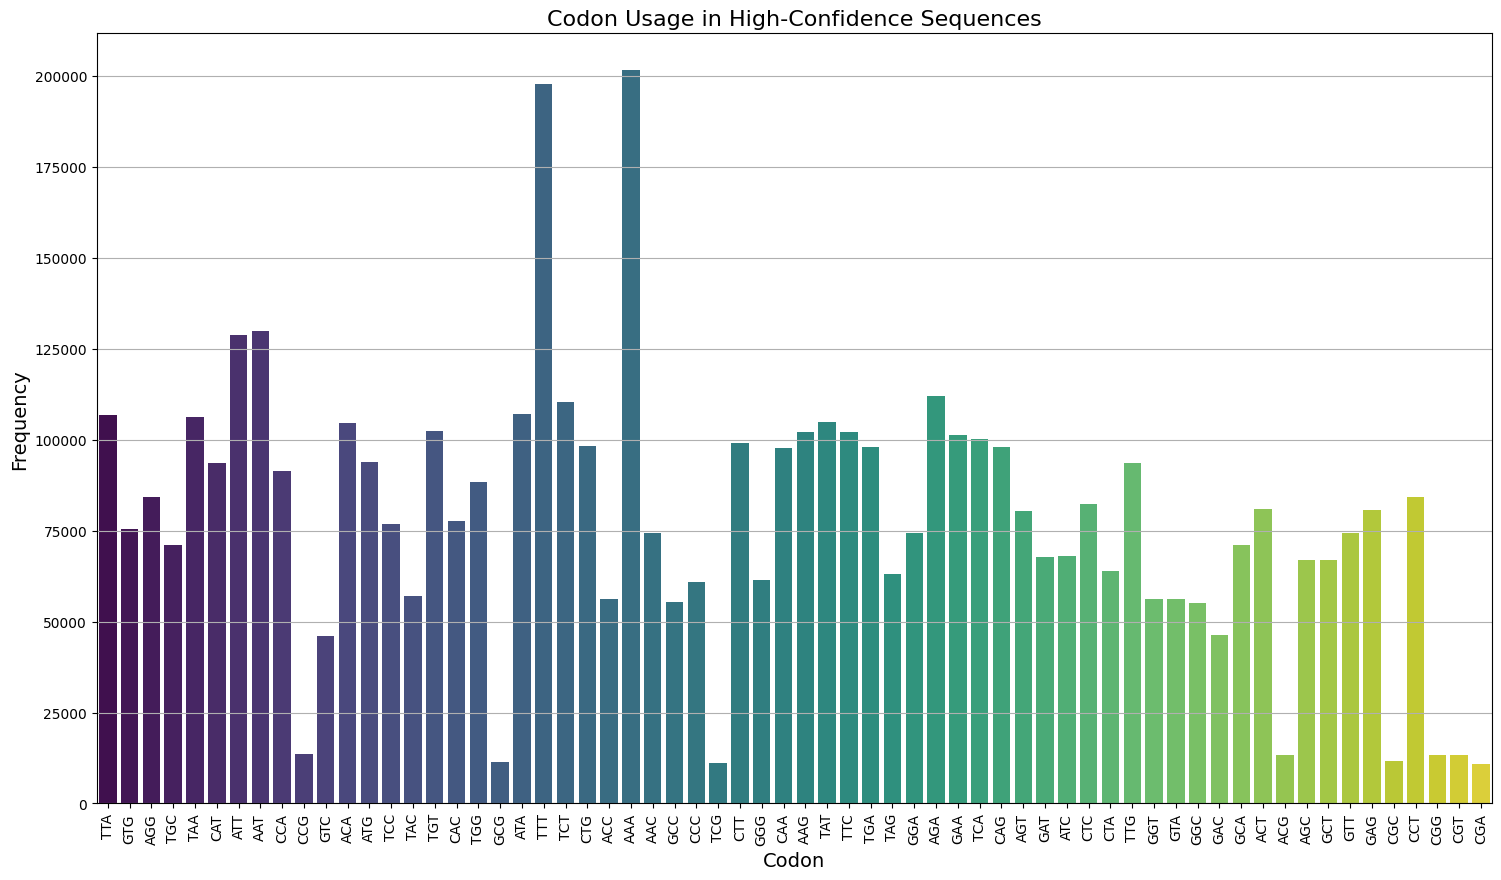

In [10]:
###Step 6: Codon Usage Analysis
## code calculates and visualizes the codon usage across all high-confidence sequences.

from collections import Counter

def codon_usage(seq):
    codons = [str(seq[i:i+3]) for i in range(0, len(seq)-2, 3)]
    return Counter(codons)

#codon usage across all high confidence sequences
total_codon_usage = Counter()
for gene in high_confidence_sequences:
    total_codon_usage.update(codon_usage(gene.seq))

#converts codon usage to DataFrame
codon_df = pd.DataFrame.from_dict(total_codon_usage, orient='index', columns=['count']).reset_index()
codon_df = codon_df.rename(columns={'index': 'codon'})

#plot
plt.figure(figsize=(18, 10))
sns.barplot(x='codon', y='count', data=codon_df, palette="viridis", hue='codon', dodge=False, legend=False)
plt.xticks(rotation=90)
plt.title("Codon Usage in High-Confidence Sequences", fontsize=16)
plt.xlabel("Codon", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y')
plt.show()


c:\Users\eligi\AppData\Local\Programs\Python\Python312\Lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


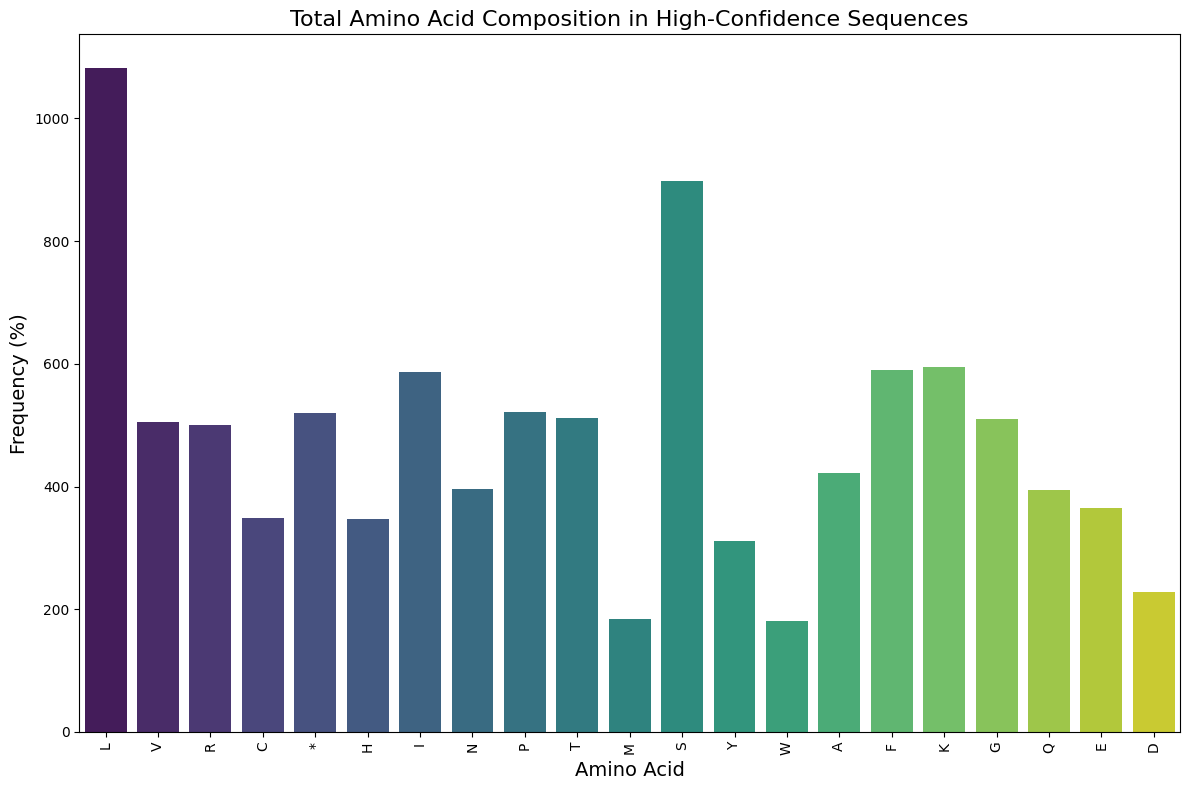

Total amino acid composition results saved to total_aa_composition_results.csv


In [13]:
## Step 7: Amino Acid Composition Analysis
## This code calculates and visualizes the amino acid composition of the high-confidence sequences.

#amino acid composition
def amino_acid_composition(seq):
    aa_freq = Counter(seq)
    total_aa = sum(aa_freq.values())
    for aa in aa_freq:
        aa_freq[aa] = aa_freq[aa] / total_aa * 100
    return aa_freq

#initializes a Counter to accumulate amino acid frequencies
total_aa_composition = Counter()

#calculates amino acid composition for each high-confidence sequence and accumulate
for gene in high_confidence_sequences:
    aa_comp = amino_acid_composition(gene.seq.translate())
    total_aa_composition.update(aa_comp)

#convert to DataFrame for plotting
aa_composition_df = pd.DataFrame.from_dict(total_aa_composition, orient='index', columns=['Frequency']).reset_index()
aa_composition_df = aa_composition_df.rename(columns={'index': 'Amino Acid'})

#plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Amino Acid', y='Frequency', data=aa_composition_df, palette="viridis", hue='Amino Acid', dodge=False, legend=False)
plt.title("Total Amino Acid Composition in High-Confidence Sequences", fontsize=16)
plt.xlabel("Amino Acid",fontsize=14)
plt.ylabel("Frequency (%)", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#saves amino acid composition results to CSV
aa_composition_df.to_csv("total_aa_composition_results.csv", index=False)
print("Total amino acid composition results saved to total_aa_composition_results.csv")

In [12]:
#Results and Discussion

#The project successfully predicted genes from the given genome, performed BLAST analysis to filter high-confidence sequences, and analyzed these sequences for various properties:

    #GC Content: The distribution of GC content was visualized and summarized.
    #Codon Usage: The frequency of each codon across all high-confidence sequences was plotted.
    #Amino Acid Composition: The overall amino acid composition was analyzed and visualized.

#The generated plots and CSV files provide a detailed overview of the genetic and protein-coding properties of the high-confidence gene sequences.